## SEA-POL QVP data

In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc, colors, ticker
import matplotlib.dates as mdates
from scipy.interpolate import interp2d, RectBivariateSpline
from datetime import datetime, timedelta
import pandas as pd
import cftime
import seaborn as sns
import json
from matplotlib import rc
from matplotlib.colors import LogNorm
from matplotlib.colors import ListedColormap
import matplotlib.colors as mcolors
import matplotlib.ticker as mticker
import cmweather
import cmocean
import cartopy
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import glob
import os

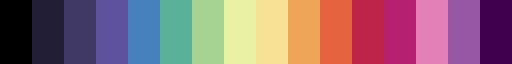

In [2]:
# Load colormap

# Read the colormap from a .txt file
def load_colormap_from_txt(file_path):
    # Load RGB values from the file
    rgb_values = np.loadtxt(file_path)
    return ListedColormap(rgb_values)

# Example usage
colormap_file = 'chase-spectral-rgb.txt'  # Replace with your .txt file path
radar_cmap = load_colormap_from_txt(colormap_file)

discrete_cmap = ListedColormap(radar_cmap(np.linspace(0, 1, 16)))
discrete_mask_cmap = discrete_cmap.copy()
discrete_mask_cmap.set_under(color='white') #set values below vmin to white
discrete_mask_cmap.set_bad(color='white') #set missing (NaN) values to white
discrete_mask_cmap

# Load volume data and generate 1D profiles

In [ ]:
# Load data
file_dirs = glob.glob("/huracan/tank4/cornell/ORCESTRA/sea-pol/qc_data/level4a/qvp_volume/202408*")

# loop through directories
for file_dir in file_dirs:
    # get the date from the directory name
    date = os.path.basename(file_dir)
    print(f"Processing data for {date}")

    file_paths = glob.glob(file_dir+"/*.nc")
    qvp = xr.open_mfdataset(file_paths, combine='by_coords')

    # Mask the data
    # missing data (blocking sectors)
    #rainrate = qvp.RATE_CSU_BLENDED.where(qvp.RATE_CSU_BLENDED >=-30000, np.nan)
    dbz = qvp.DBZ.where(qvp.DBZ >=-30000, np.nan)

    #change -9999 missing data to zeros for rain, NaN for DBZ
    #rainrate2 = rainrate.where(rainrate != -9999, 0)
    dbz2 = dbz.where(dbz != -9999, np.nan)

    #convert from log to linear
    reflectivity = 10**(dbz2/10)

    # Average spatially at each level (results in time x height)
    #rainrate_avg = rainrate2.mean(dim=['X', 'Y'],skipna=True)
    reflectivity_avg = reflectivity.mean(dim=['X', 'Y'],skipna=True) 
    #rainrate_cond = rainrate2.where(rainrate2>0).mean(dim=('X','Y'),skipna=True)

    #convert back to dBZ
    dbz_avg = 10*np.log10(reflectivity_avg)

    # Save to netcdf file
    #rainrate_avg.attrs['units'] = 'mm/h'
    #rainrate_cond.attrs['units'] = 'mm/h'
    dbz_avg.attrs['units'] = 'dBZ'

    #combine into one dataset
    #qvp1D= xr.Dataset({'rainrate_avg': rainrate_avg, 'dbz_avg': dbz_avg, 'rainrate_int': rainrate_cond})
    qvp1D= xr.Dataset({'dbz_avg': dbz_avg})

    #add attributes
    qvp1D.attrs['title'] = 'Average rain rate and reflectivity at each altitude from SEA-POL QVP'
    qvp1D.attrs['description'] = 'Spatial means of rainrate from SEA-POL 45 degree elevation scans at different altitudes. Mean is the average over all valid data points (including zeros). Int (intensity) is the average over all data points where rainrate > 0.'
    qvp1D.attrs['source'] = 'SEA-POL Level4a QVP Volume'

    #save to netcdf
    qvp1D.to_netcdf('/huracan/tank4/cornell/ORCESTRA/sea-pol/qc_data/level4a/qvp_1D/qvp_1D_'+date+'.nc', mode='w', format='NETCDF4')


In [33]:
# Collect all .nc files from multiple directories
dirs = ["/huracan/tank4/cornell/ORCESTRA/sea-pol/qc_data/level4a/qvp_volume/2024090*"]

file_paths = []
for d in dirs:
    file_paths.extend(glob.glob(d + "/*.nc"))

# Open all files as a single xarray dataset
qvp = xr.open_mfdataset(file_paths, combine='by_coords')

In [34]:
# reshape to be a function of height only
qvpdbz = qvp.DBZ.values
qvpdbz = qvpdbz.reshape(qvpdbz.shape[0]*qvpdbz.shape[2]*qvpdbz.shape[3], qvpdbz.shape[1])
qvpdbz

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]],
      shape=(166550238, 181), dtype=float32)

Testing how to open multiple files and take 1D average

In [ ]:
# Load data
file_paths = glob.glob("/huracan/tank4/cornell/ORCESTRA/sea-pol/qc_data/level4a/qvp_volume/20240903/*.nc")

#Open the files and combine them into a single dataset
qvp = xr.open_mfdataset(file_paths,combine='by_coords')
qvp

In [ ]:
# Mask the data
# missing data (blocking sectors)
rainrate = qvp.RATE_CSU_BLENDED.where(qvp.RATE_CSU_BLENDED >=-30000, np.nan)
dbz = qvp.DBZ.where(qvp.DBZ >=-30000, np.nan)

#change -9999 missing data to zeros for rain, NaN for DBZ
rainrate2 = rainrate.where(rainrate != -9999, 0)
dbz2 = dbz.where(dbz != -9999, np.nan)

In [ ]:
#convert from log to linear
reflectivity = 10**(dbz2/10)

# Average spatially at each level (results in time x height)
rainrate_avg = rainrate2.mean(dim=['X', 'Y'],skipna=True)
reflectivity_avg = reflectivity.mean(dim=['X', 'Y'],skipna=True)

#convert back to dBZ
dbz_avg = 10*np.log10(reflectivity_avg)
dbz_avg

# Read in individual 1D files and concatenate

In [4]:
# Load data
file_paths = glob.glob("/huracan/tank4/cornell/ORCESTRA/sea-pol/qc_data/level4a/qvp_1D/*.nc")

#Open the files and combine them into a single dataset
qvp = xr.open_mfdataset(file_paths,combine='by_coords')

#Write out to a single file
qvp.to_netcdf('/huracan/tank4/cornell/ORCESTRA/sea-pol/qc_data/level4a/qvp_1D/qvp_1D.nc', mode='w', format='NETCDF4')


# Open concatenated 1D data and make plots

In [3]:
#qvp = xr.open_dataset('/huracan/tank4/cornell/ORCESTRA/sea-pol/qc_data/level4a/qvp_1D/qvp_1D.nc')
#qvp = xr.open_dataset('/huracan/tank4/cornell/ORCESTRA/sea-pol/qc_data/level4a/qvp_1d/PICCOLO_gridded_qvp_1d.nc')
#qvp = xr.open_dataset('/huracan/tank4/cornell/ORCESTRA/sea-pol/qc_data/level4b/PICCOLO_level4b_qvp_1D.nc')
qvp = xr.open_dataset('/huracan/tank4/cornell/ORCESTRA/sea-pol/qc_data/level4/PICCOLO_level4_qvp_1D.nc')
qvp

<xarray.Dataset> Size: 36MB
Dimensions:       (time: 4966, Z: 181)
Coordinates:
  * Z             (Z) float32 724B 0.0 100.0 200.0 ... 1.78e+04 1.79e+04 1.8e+04
    latitude      (time) float32 20kB ...
    longitude     (time) float32 20kB ...
  * time          (time) datetime64[ns] 40kB 2024-08-16T08:10:00 ... 2024-09-...
Data variables: (12/13)
    DBZ           (time, Z) float32 4MB ...
    KDP           (time, Z) float32 4MB ...
    PHIDP         (time, Z) float32 4MB ...
    RAINRATE      (time, Z) float32 4MB ...
    RHOHV         (time, Z) float32 4MB ...
    SQI           (time, Z) float32 4MB ...
    ...            ...
    VEL           (time, Z) float32 4MB ...
    WIDTH         (time, Z) float32 4MB ...
    ZDR           (time, Z) float32 4MB ...
    grid_mapping  int32 4B ...
    start_time    (time) datetime64[ns] 40kB ...
    stop_time     (time) datetime64[ns] 40kB ...
Attributes: (12/14)
    Conventions:       CF-1.12
    institution:       Colorado State University
    source:            CSU SEA-POL radar
    instrument:        SEA-POL
    title:             Level 4 Gridded SEA-POL Radar Data
    summary:           Level 4 Gridded SEA-POL Radar Data
    ...                ...
    creator_id:        https://orcid.org/0000-0002-0496-331X
    project:           PICCOLO, BOWTIE, ORCESTRA
    platform:          RV METEOR
    keywords:          radar, precipitation, sea-pol
    processing_level:  Level 4
    license:           CC-BY-4.0

In [4]:
# Mask the data
# missing data (blocking sectors)
rainrate = qvp.RAINRATE.where(qvp.RAINRATE >=-30000, np.nan)
dbz = qvp.DBZ.where(qvp.DBZ >=-30000, np.nan)

#change -9999 missing data to zeros for rain, NaN for DBZ
rainrate2 = rainrate.where(rainrate != -9999, 0)
dbz2 = dbz.where(dbz != -9999, np.nan)

/tmp/ipykernel_106103/1674006010.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), fontsize=18)
/tmp/ipykernel_106103/1674006010.py:18: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=18)


(np.float64(19951.0), np.float64(19990.0))

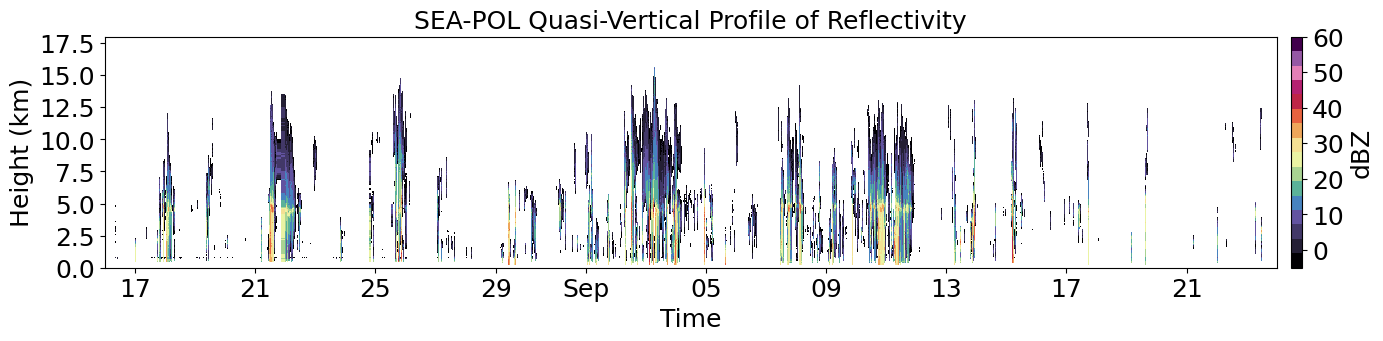

In [5]:
#plot over entire cruise
fig,ax = plt.subplots(figsize=(18,3))
cax = ax.pcolormesh(qvp.time, qvp.Z/1000, dbz.transpose(), cmap=discrete_mask_cmap, vmin=-5,vmax=60, shading='auto')
ax.set_ylim(0,18)
ax.set_xlim(pd.to_datetime('2024-08-16T00:00:00'), pd.to_datetime('2024-09-24T00:00:00'))

cbar = fig.colorbar(cax, ax=ax, orientation='vertical', pad=0.01)
cbar.ax.tick_params(labelsize=18)
cbar.set_ticks(np.arange(0,61,10))
cbar.set_label('dBZ', fontsize=18)

ax.xaxis.set_major_locator(mdates.AutoDateLocator())
ax.xaxis.set_major_formatter(mdates.ConciseDateFormatter(ax.xaxis.get_major_locator()))
ax.set_title('SEA-POL Quasi-Vertical Profile of Reflectivity',fontsize=18)   
ax.set_ylabel('Height (km)', fontsize=18)
ax.set_xlabel('Time',fontsize=18)
ax.set_xticklabels(ax.get_xticklabels(), fontsize=18)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=18)
ax.set_xlim(pd.to_datetime('2024-08-16T00:00:00'), pd.to_datetime('2024-09-24T00:00:00'))

In [40]:
# Search times
time1 = np.datetime64('2024-08-25T09:00:00')
time2 = np.datetime64('2024-08-25T16:00:00')

#Find indices for start and end times
index1 = np.abs(pd.to_datetime(qvp.time) - time1).argmin()
index2 = np.abs(pd.to_datetime(qvp.time) - time2).argmin()

In [41]:
qvp.time[index1:index2+1]

<xarray.DataArray 'time' (time: 20)> Size: 160B
array(['2024-08-25T09:00:00.000000000', '2024-08-25T09:10:00.000000000',
       '2024-08-25T09:20:00.000000000', '2024-08-25T09:30:00.000000000',
       '2024-08-25T09:40:00.000000000', '2024-08-25T09:50:00.000000000',
       '2024-08-25T10:00:00.000000000', '2024-08-25T10:10:00.000000000',
       '2024-08-25T10:20:00.000000000', '2024-08-25T10:30:00.000000000',
       '2024-08-25T10:40:00.000000000', '2024-08-25T13:40:00.000000000',
       '2024-08-25T14:50:00.000000000', '2024-08-25T15:00:00.000000000',
       '2024-08-25T15:10:00.000000000', '2024-08-25T15:20:00.000000000',
       '2024-08-25T15:30:00.000000000', '2024-08-25T15:40:00.000000000',
       '2024-08-25T15:50:00.000000000', '2024-08-25T16:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
    latitude   (time) float32 80B 9.757 9.758 9.759 9.76 ... 10.47 10.51 10.54
    longitude  (time) float32 80B -24.22 -24.22 -24.23 ... -24.12 -24.12 -24.11
  * time       (time) datetime64[ns] 160B 2024-08-25T09:00:00 ... 2024-08-25T...
Attributes:
    standard_name:  time
    long_name:      Data time
    axis:           T
    comment:        
    cell_methods:   time: mean

/tmp/ipykernel_106103/752130610.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), fontsize=18)
/tmp/ipykernel_106103/752130610.py:18: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=18)


[Text(0, 0.0, '0.0'),
 Text(0, 2.5, '2.5'),
 Text(0, 5.0, '5.0'),
 Text(0, 7.5, '7.5'),
 Text(0, 10.0, '10.0'),
 Text(0, 12.5, '12.5'),
 Text(0, 15.0, '15.0'),
 Text(0, 17.5, '17.5'),
 Text(0, 20.0, '20.0')]

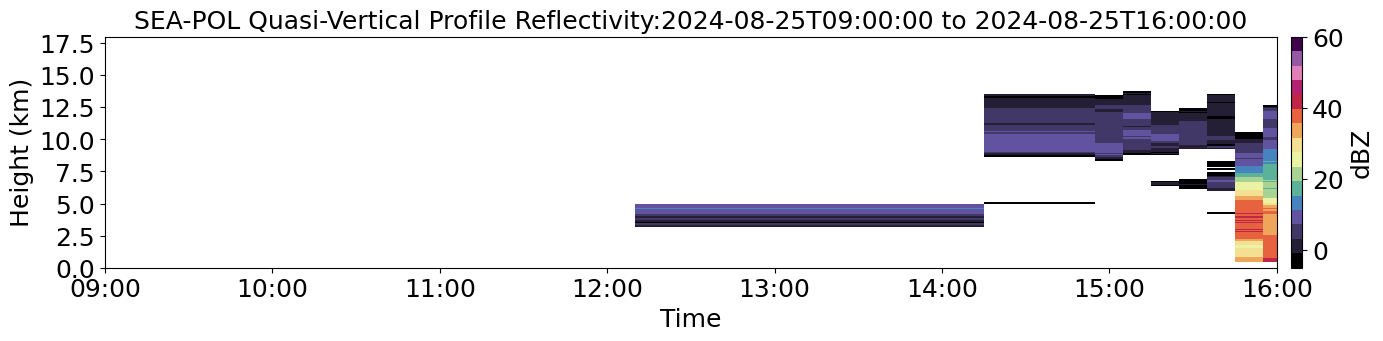

In [42]:
#plot over time period
fig,ax = plt.subplots(figsize=(18,3))
cax = ax.pcolormesh(qvp.time[index1:index2+1], qvp.Z/1000, qvp.DBZ[index1:index2+1,:].transpose(), cmap=discrete_mask_cmap, vmin=-5,vmax=60,shading='auto')
ax.set_xlim(pd.to_datetime(time1), pd.to_datetime(time2))
ax.set_ylim(0,18)

cbar = fig.colorbar(cax, ax=ax, orientation='vertical', pad=0.01)
cbar.ax.tick_params(labelsize=18)
#cbar.set_ticks(np.arange(-10,61,10))
cbar.set_label('dBZ', fontsize=18)

ax.set_title('SEA-POL Quasi-Vertical Profile Reflectivity:' + str(time1) + ' to ' + str(time2),fontsize=18)  
ax.xaxis.set_major_locator(mdates.AutoDateLocator())
ax.xaxis.set_major_formatter(mdates.ConciseDateFormatter(ax.xaxis.get_major_locator()))
ax.set_ylabel('Height (km)', fontsize=18)
ax.set_xlabel('Time',fontsize=18)
ax.set_xticklabels(ax.get_xticklabels(), fontsize=18)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=18)

/tmp/ipykernel_106103/2795266051.py:19: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), fontsize=18)
/tmp/ipykernel_106103/2795266051.py:20: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=18)


[Text(0, 0.0, '0.0'),
 Text(0, 2.5, '2.5'),
 Text(0, 5.0, '5.0'),
 Text(0, 7.5, '7.5'),
 Text(0, 10.0, '10.0'),
 Text(0, 12.5, '12.5'),
 Text(0, 15.0, '15.0'),
 Text(0, 17.5, '17.5'),
 Text(0, 20.0, '20.0')]

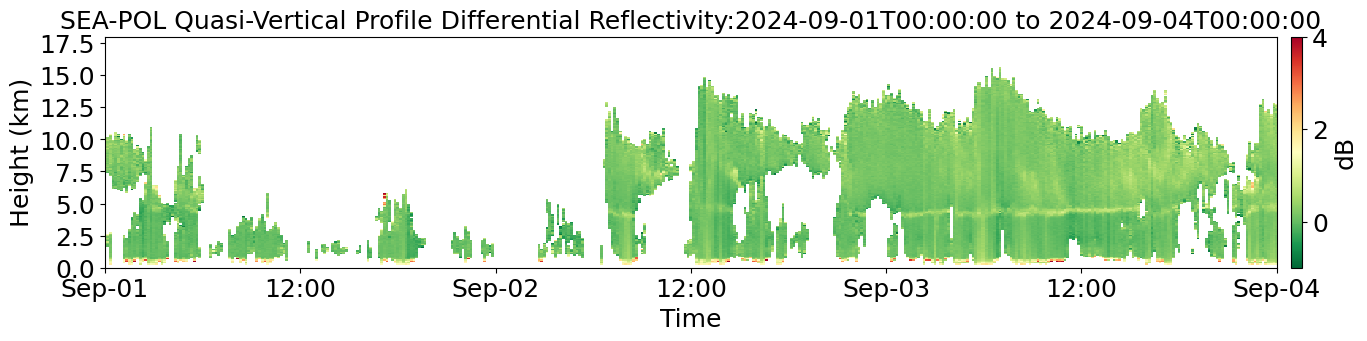

In [8]:
#plot over time period
fig,ax = plt.subplots(figsize=(18,3))
zdr_cmap=plt.get_cmap('RdYlGn_r').copy()
zdr_cmap.set_under(color='white') #set values below vmin to white
cax = ax.pcolormesh(qvp.time[index1:index2+1], qvp.Z/1000, qvp.ZDR[index1:index2+1,:].transpose(), cmap=zdr_cmap, vmin=-1, vmax=4, shading='auto')
ax.set_xlim(pd.to_datetime(time1), pd.to_datetime(time2))
ax.set_ylim(0,18)

cbar = fig.colorbar(cax, ax=ax, orientation='vertical', pad=0.01)
cbar.ax.tick_params(labelsize=18)
#cbar.set_ticks(np.arange(-10,61,10))
cbar.set_label('dB', fontsize=18)

ax.set_title('SEA-POL Quasi-Vertical Profile Differential Reflectivity:' + str(time1) + ' to ' + str(time2),fontsize=18)  
ax.xaxis.set_major_locator(mdates.AutoDateLocator())
ax.xaxis.set_major_formatter(mdates.ConciseDateFormatter(ax.xaxis.get_major_locator()))
ax.set_ylabel('Height (km)', fontsize=18)
ax.set_xlabel('Time',fontsize=18)
ax.set_xticklabels(ax.get_xticklabels(), fontsize=18)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=18)

/tmp/ipykernel_106103/130299457.py:19: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), fontsize=18)
/tmp/ipykernel_106103/130299457.py:20: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=18)


[Text(0, 0.0, '0.0'),
 Text(0, 2.5, '2.5'),
 Text(0, 5.0, '5.0'),
 Text(0, 7.5, '7.5'),
 Text(0, 10.0, '10.0'),
 Text(0, 12.5, '12.5'),
 Text(0, 15.0, '15.0'),
 Text(0, 17.5, '17.5'),
 Text(0, 20.0, '20.0')]

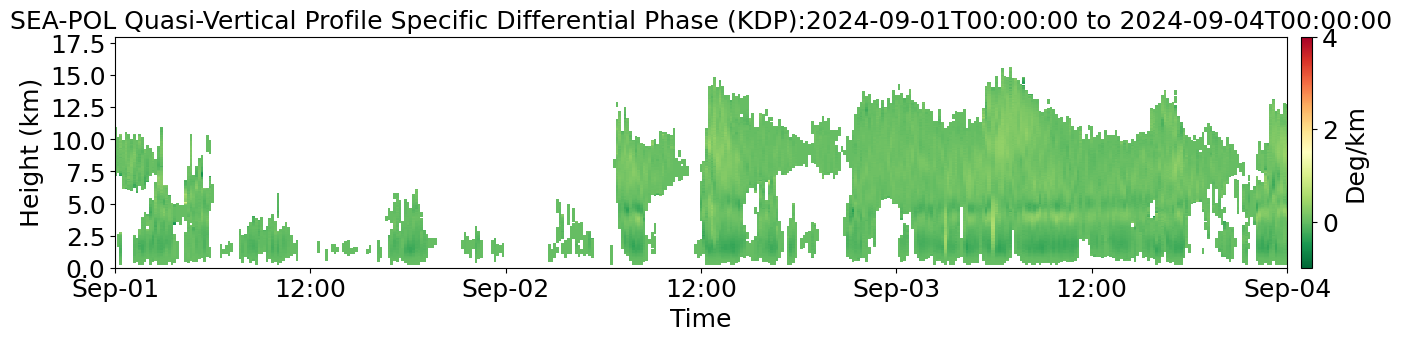

In [9]:
#plot over time period
fig,ax = plt.subplots(figsize=(18,3))
zdr_cmap=plt.get_cmap('RdYlGn_r').copy()
zdr_cmap.set_under(color='white') #set values below vmin to white
cax = ax.pcolormesh(qvp.time[index1:index2+1], qvp.Z/1000, qvp.KDP[index1:index2+1,:].transpose(), cmap=zdr_cmap, vmin=-1, vmax=4, shading='auto')
ax.set_xlim(pd.to_datetime(time1), pd.to_datetime(time2))
ax.set_ylim(0,18)

cbar = fig.colorbar(cax, ax=ax, orientation='vertical', pad=0.01)
cbar.ax.tick_params(labelsize=18)
#cbar.set_ticks(np.arange(-10,61,10))
cbar.set_label('Deg/km', fontsize=18)

ax.set_title('SEA-POL Quasi-Vertical Profile Specific Differential Phase (KDP):' + str(time1) + ' to ' + str(time2),fontsize=18)  
ax.xaxis.set_major_locator(mdates.AutoDateLocator())
ax.xaxis.set_major_formatter(mdates.ConciseDateFormatter(ax.xaxis.get_major_locator()))
ax.set_ylabel('Height (km)', fontsize=18)
ax.set_xlabel('Time',fontsize=18)
ax.set_xticklabels(ax.get_xticklabels(), fontsize=18)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=18)

/tmp/ipykernel_106103/2658317905.py:19: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), fontsize=18)
/tmp/ipykernel_106103/2658317905.py:20: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=18)


[Text(0, 0.0, '0.0'),
 Text(0, 2.5, '2.5'),
 Text(0, 5.0, '5.0'),
 Text(0, 7.5, '7.5'),
 Text(0, 10.0, '10.0'),
 Text(0, 12.5, '12.5'),
 Text(0, 15.0, '15.0'),
 Text(0, 17.5, '17.5'),
 Text(0, 20.0, '20.0')]

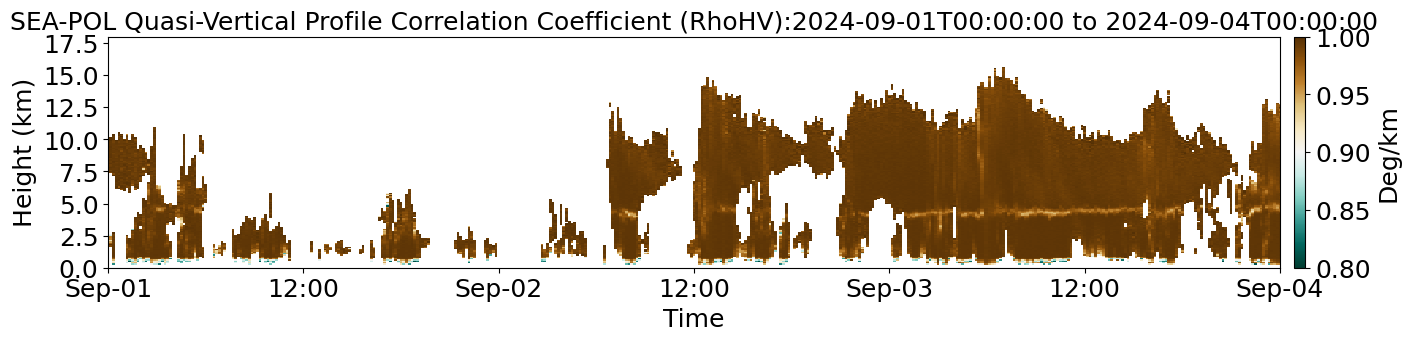

In [10]:
#plot over time period
fig,ax = plt.subplots(figsize=(18,3))
zdr_cmap=plt.get_cmap('BrBG_r').copy()
zdr_cmap.set_under(color='white') #set values below vmin to white
cax = ax.pcolormesh(qvp.time[index1:index2+1], qvp.Z/1000, qvp.RHOHV[index1:index2+1,:].transpose(), cmap=zdr_cmap, vmin=0.8, vmax=1, shading='auto')
ax.set_xlim(pd.to_datetime(time1), pd.to_datetime(time2))
ax.set_ylim(0,18)

cbar = fig.colorbar(cax, ax=ax, orientation='vertical', pad=0.01)
cbar.ax.tick_params(labelsize=18)
#cbar.set_ticks(np.arange(-10,61,10))
cbar.set_label('Deg/km', fontsize=18)

ax.set_title('SEA-POL Quasi-Vertical Profile Correlation Coefficient (RhoHV):' + str(time1) + ' to ' + str(time2),fontsize=18)  
ax.xaxis.set_major_locator(mdates.AutoDateLocator())
ax.xaxis.set_major_formatter(mdates.ConciseDateFormatter(ax.xaxis.get_major_locator()))
ax.set_ylabel('Height (km)', fontsize=18)
ax.set_xlabel('Time',fontsize=18)
ax.set_xticklabels(ax.get_xticklabels(), fontsize=18)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=18)

/tmp/ipykernel_106103/2414341593.py:19: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), fontsize=18)
/tmp/ipykernel_106103/2414341593.py:20: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=18)


[Text(0, 0.0, '0.0'),
 Text(0, 2.5, '2.5'),
 Text(0, 5.0, '5.0'),
 Text(0, 7.5, '7.5'),
 Text(0, 10.0, '10.0'),
 Text(0, 12.5, '12.5'),
 Text(0, 15.0, '15.0'),
 Text(0, 17.5, '17.5'),
 Text(0, 20.0, '20.0')]

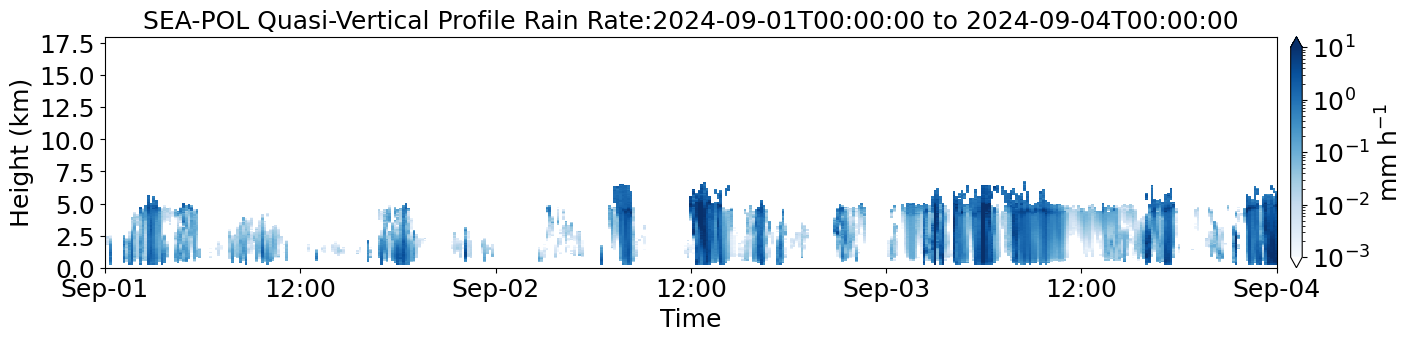

In [11]:
#plot over time period
fig,ax = plt.subplots(figsize=(18,3))
rain_cmap=plt.get_cmap('Blues').copy()
rain_cmap.set_under(color='white') #set values below vmin to white
cax = ax.pcolormesh(qvp.time[index1:index2+1], qvp.Z/1000, rainrate[index1:index2+1,:].transpose(), cmap=rain_cmap, norm=colors.LogNorm(vmin=0.001,vmax=10),shading='auto')
ax.set_xlim(pd.to_datetime(time1), pd.to_datetime(time2))
ax.set_ylim(0,18)

cbar = fig.colorbar(cax, ax=ax, orientation='vertical', extend='both',pad=0.01)
cbar.ax.tick_params(labelsize=18)
#cbar.set_ticks(np.arange(0.01,1,1e-2))
cbar.set_label('mm h$^{-1}$', fontsize=18)

ax.set_title('SEA-POL Quasi-Vertical Profile Rain Rate:' + str(time1) + ' to ' + str(time2),fontsize=18)  
ax.xaxis.set_major_locator(mdates.AutoDateLocator())
ax.xaxis.set_major_formatter(mdates.ConciseDateFormatter(ax.xaxis.get_major_locator()))
ax.set_ylabel('Height (km)', fontsize=18)
ax.set_xlabel('Time',fontsize=18)
ax.set_xticklabels(ax.get_xticklabels(), fontsize=18)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=18)

# CFAD of radar reflectivity

In [12]:
def compute_cfad(invar, bins):
    nz = invar.shape[1]
    nbin = len(bins)
    hist_density=np.zeros((nbin-1,nz))
    for iz in range(nz):
        count, bin_edges = np.histogram(invar[:,iz], bins=bins, density=True)
        hist_density[:,iz] = count
    return hist_density, bin_edges

In [13]:
# Set BP and AP times
BPtime = np.datetime64('2024-08-28T06:00:00')
APtime = np.datetime64('2024-08-28T20:00:00')

#Find indices for start and end times
indexBP = np.abs(pd.to_datetime(qvp.time) - BPtime).argmin()
indexAP = np.abs(pd.to_datetime(qvp.time) - APtime).argmin()

In [18]:
# Compute CFAD

nbin = 130
fmin = -70
fmax = 61
bins = np.linspace(fmin,fmax,nbin+1)

cfad_density, bin_edges = compute_cfad(qvp.DBZ, bins)

/home/awing/.conda/envs/orcestra/lib/python3.13/site-packages/numpy/lib/_histograms_impl.py:901: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges


/tmp/ipykernel_106103/1280682185.py:16: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), fontsize=18)
/tmp/ipykernel_106103/1280682185.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=18)


[Text(0, 0.0, '0'),
 Text(0, 2.0, '2'),
 Text(0, 4.0, '4'),
 Text(0, 6.0, '6'),
 Text(0, 8.0, '8'),
 Text(0, 10.0, '10'),
 Text(0, 12.0, '12'),
 Text(0, 14.0, '14'),
 Text(0, 16.0, '16'),
 Text(0, 18.0, '18')]

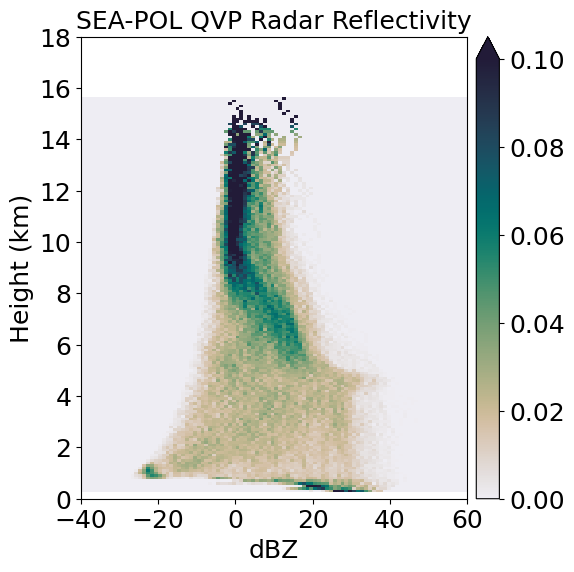

In [19]:
# Plot CFAD

fig,ax = plt.subplots(figsize=(6,6))

cfad = ax.pcolormesh(bins[:-1],qvp.Z/1000,cfad_density.transpose(),cmap=cmocean.cm.rain,norm=colors.Normalize(vmin=0,vmax=0.1),shading='nearest')
#cfad = ax.pcolormesh(bins[:-1],qvp.Z/1000,cfad_density.transpose(),cmap=cmocean.cm.rain, vmin=0, vmax=80, shading='nearest')  

cbar=plt.colorbar(cfad,location='right',orientation='vertical', extend='max',pad=0.02)
cbar.ax.tick_params(labelsize=18)

ax.set_xlim(-40,60)
ax.set_ylim(0,18)
ax.set_title('SEA-POL QVP Radar Reflectivity',fontsize=18)
ax.set_ylabel('Height (km)', fontsize=18)
ax.set_xlabel('dBZ',fontsize=18)
ax.set_xticklabels(ax.get_xticklabels(), fontsize=18)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=18)

/tmp/ipykernel_4004037/1280682185.py:16: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), fontsize=18)
/tmp/ipykernel_4004037/1280682185.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=18)


[Text(0, 0.0, '0'),
 Text(0, 2.0, '2'),
 Text(0, 4.0, '4'),
 Text(0, 6.0, '6'),
 Text(0, 8.0, '8'),
 Text(0, 10.0, '10'),
 Text(0, 12.0, '12'),
 Text(0, 14.0, '14'),
 Text(0, 16.0, '16'),
 Text(0, 18.0, '18')]

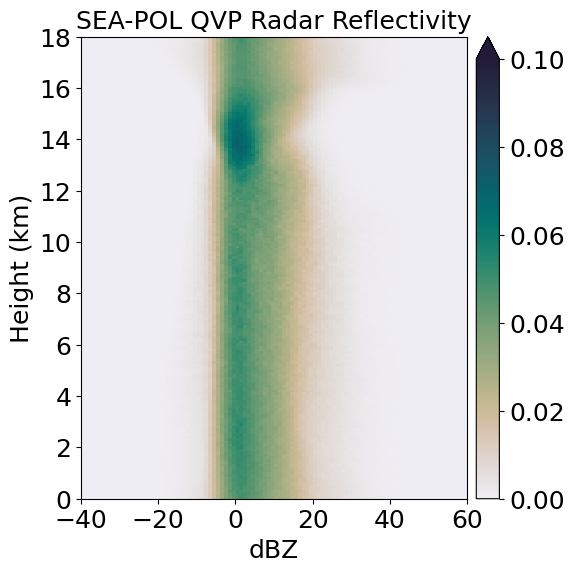

In [38]:
# Plot CFAD

fig,ax = plt.subplots(figsize=(6,6))

cfad = ax.pcolormesh(bins[:-1],qvp.Z/1000,cfad_density.transpose(),cmap=cmocean.cm.rain,norm=colors.Normalize(vmin=0,vmax=0.1),shading='nearest')
#cfad = ax.pcolormesh(bins[:-1],qvp.Z/1000,cfad_density.transpose(),cmap=cmocean.cm.rain, vmin=0, vmax=80, shading='nearest')  

cbar=plt.colorbar(cfad,location='right',orientation='vertical', extend='max',pad=0.02)
cbar.ax.tick_params(labelsize=18)

ax.set_xlim(-40,60)
ax.set_ylim(0,18)
ax.set_title('SEA-POL QVP Radar Reflectivity',fontsize=18)
ax.set_ylabel('Height (km)', fontsize=18)
ax.set_xlabel('dBZ',fontsize=18)
ax.set_xticklabels(ax.get_xticklabels(), fontsize=18)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=18)

for the above, I tried to do the CFAD from the QVP volume data (reshaping from time,z,y,x to time*y*x,z) but whether I do it just for one day or for 10 days, it looks like this which...doesn't look right. So maybe doing the CFAD from the QVP 1D average is better? I was just worried it was averaging too much. 